## K-Means Analysis Plots and Pipeline Check 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
# ROOT_DIR = Path(os.getcwd())
ROOT_DIR = "d:/Desktop/Data Science Learning/DS Self Projects/IITG Capstone/Stock Market Anomaly Detection/stock-anomaly-detector/"

In [3]:
import os
import sys

# Set the project root directory
project_root = ROOT_DIR

# Change the working directory to the project root
os.chdir(project_root)


# Adding the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
from src.detectors.kmeans import (
    build_feature_matrix,
    split_by_date,
    scale_features,
    fit_kmeans,
    compute_kmeans_distance,
    compute_cluster_thresholds,
    detect_kmeans_anomaly
)

In [5]:
from src.detectors.rules import detect_rule_anomaly

from src.features.range import compute_range_percentile
from src.features.returns import compute_daily_return, compute_return_zscore
from src.features.volume import compute_volume_zscore

from src.data.load import load_ticker_csv
from src.data.clean_ohlcv import clean_ohlcv
from src.data.validate import validate_ohlcv

#### A: Load Tickers & Compute Features

In [6]:
DATA_PATH = ROOT_DIR + "data/raw"
PATH = Path(DATA_PATH)

tickers = ["QQQ", "AMZN", "GOOGL", "MSFT", "NVDA", "TSLA", "FB"]

feature_frames = []

for ticker in tickers:

    df = load_ticker_csv(PATH / f"{ticker}.csv")
    df, issues = validate_ohlcv(df)

    if issues:
        df = clean_ohlcv(df, issues, ticker)
        validate_ohlcv(df, strict=True)

    # compute features
    ret = compute_daily_return(df)
    ret_z = compute_return_zscore(ret)
    vol_z = compute_volume_zscore(df["volume"])
    range_pct = compute_range_percentile(df)

    feat_df = pd.DataFrame({
        "date": df["date"],
        "ticker": ticker,
        "ret": ret,
        "ret_z": ret_z,
        "vol_z": vol_z,
        "range_pct": range_pct
    })

    feature_frames.append(feat_df)

df_features = pd.concat(feature_frames, ignore_index=True)

df_features.head()


2026-01-03 01:45:26,229 - INFO - [data.load]: ✅ All required columns exist
2026-01-03 01:45:26,235 - INFO - QQQ | Row Count before: 5301
2026-01-03 01:45:26,235 - INFO - QQQ | Row Count after: 5300
2026-01-03 01:45:26,235 - INFO - QQQ | Reasons:
2026-01-03 01:45:26,235 - INFO - High < max(open, close, low)
2026-01-03 01:45:28,183 - INFO - [data.load]: ✅ All required columns exist
2026-01-03 01:45:30,369 - INFO - [data.load]: ✅ All required columns exist
2026-01-03 01:45:31,911 - INFO - [data.load]: ✅ All required columns exist
2026-01-03 01:45:35,111 - INFO - [data.load]: ✅ All required columns exist
d:\Desktop\Data Science Learning\DS Self Projects\IITG Capstone\Stock Market Anomaly Detection\stock-anomaly-detector\src\features\returns.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  d

,date,ticker,ret,ret_z,vol_z,range_pct
0,1999-03-10,QQQ,NaN,NaN,NaN,NaN
1,1999-03-11,QQQ,0.004896,NaN,NaN,NaN
2,1999-03-12,QQQ,-0.024361,NaN,NaN,NaN
3,1999-03-15,QQQ,0.028714,NaN,NaN,NaN
4,1999-03-16,QQQ,0.008495,NaN,NaN,NaN


In [7]:
df_features.isna().mean()

date         0.000000
ticker       0.000000
ret          0.000210
ret_z        0.013435
vol_z        0.005068
range_pct    0.013225
dtype: float64

#### B: Build Feature Matrix & Split

In [8]:
X, meta = build_feature_matrix(df_features)

X_train, X_val, X_test, meta_train, meta_val, meta_test = split_by_date(X, meta)

print(X_train.shape, X_val.shape, X_test.shape)

(1757, 3) (1763, 3) (434, 3)


#### C: Scale 

In [9]:
# scaling
scaler, X_train_s, X_val_s, X_test_s = scale_features(X_train, X_val, X_test)

#### D: Elbow Method(Training Data Only)

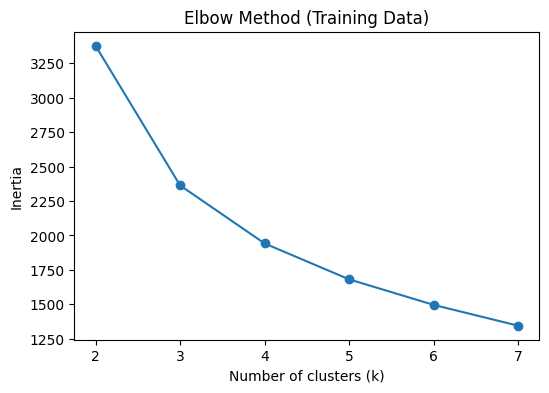

In [10]:
from sklearn.cluster import KMeans

inertias = []
k_values = range(2, 8)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_train_s)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(k_values, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method (Training Data)")
plt.savefig('reports/figures/kmeans_elbow_method.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()


#### Silhouette Score

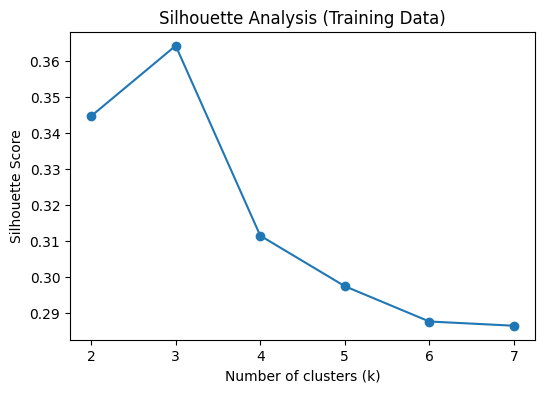

In [11]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_train_s)
    sil_scores.append(silhouette_score(X_train_s, labels))

plt.figure(figsize=(6, 4))
plt.plot(k_values, sil_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis (Training Data)")
plt.savefig(os.path.join('reports/figures/', 'kmeans_silhouette_analysis.png'), bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()


#### Decision for choosing K using Elbow and Silhouette Plots

In Elbow plot, the K=3 is the point from which the inertia value starts plateauing, this kind of stabilization states, any further increment in k value is no good, since too low inertia value will have too densed and higher number of cluster. choosing High value of inertia will lead to less clusters that have point too far from the centroids. k=3 as per the plot seems the sweet spot.

Choosing k=3 decision is further agreed by the silhouette score plot. 
As k = 3 has the highest silhouette score, making it the right choice for the k.

#### E: Fit K-Means

In [12]:
# fit kmeans

k = 3  # as agreed by Elbow and Silhouette Method

kmeans = fit_kmeans(X_train_s, k=k, random_state=42)


#### F: Compute Distances & Thresholds

In [13]:
# TRAIN distance (for thresholds)
train_dist, train_labels = compute_kmeans_distance(X_train_s, kmeans) 

thresholds = compute_cluster_thresholds(train_dist, train_labels, percentile=95) #prev 97.5

thresholds

{np.int32(0): np.float64(2.6712722472331705),
 np.int32(1): np.float64(2.0484041102958304),
 np.int32(2): np.float64(1.5139960048306482)}

#### G: Distance Distributions 

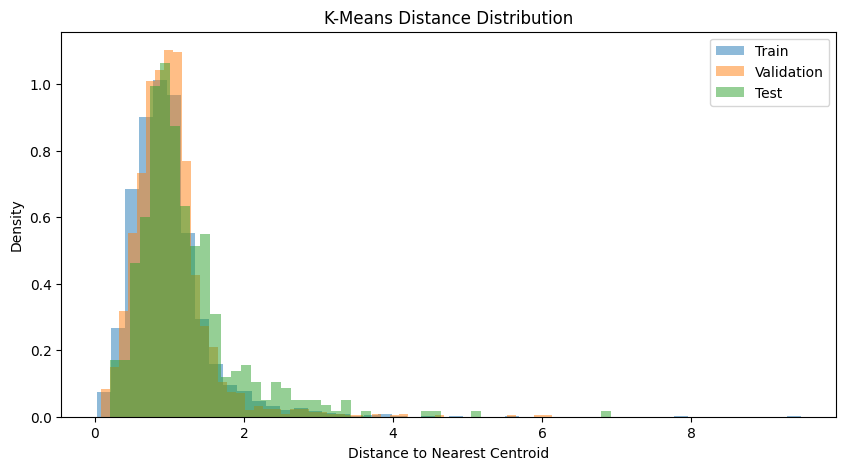

In [14]:
# VAL & TEST distances
val_dist, val_labels = compute_kmeans_distance(X_val_s, kmeans)
test_dist, test_labels = compute_kmeans_distance(X_test_s, kmeans)

plt.figure(figsize=(10, 5))

plt.hist(train_dist, bins=50, alpha=0.5, label="Train", density=True)
plt.hist(val_dist, bins=50, alpha=0.5, label="Validation", density=True)
plt.hist(test_dist, bins=50, alpha=0.5, label="Test", density=True)

plt.xlabel("Distance to Nearest Centroid")
plt.ylabel("Density")
plt.title("K-Means Distance Distribution")
plt.legend()
plt.show()


#### H: Detect K-Means Anomalies

In [15]:
df_kmeans_val = detect_kmeans_anomaly(
    distances=val_dist,
    labels=val_labels,
    thresholds=thresholds,
    meta=meta_val
)

df_kmeans_test = detect_kmeans_anomaly(
    distances=test_dist,
    labels=test_labels,
    thresholds=thresholds,
    meta=meta_test
)

print("Val anomalies:", len(df_kmeans_val))
print("Test anomalies:", len(df_kmeans_test))

df_kmeans_test.head()


Val anomalies: 97
Test anomalies: 37


,date,ticker,anomaly_flag,cluster,distance
0,2020-02-24,QQQ,1,0,3.193727
1,2020-02-27,QQQ,1,0,3.030025
2,2020-03-02,QQQ,1,1,2.995849
3,2020-03-13,QQQ,1,1,2.503699
4,2020-03-16,QQQ,1,0,2.736320


#### Anomaly Count Over Time

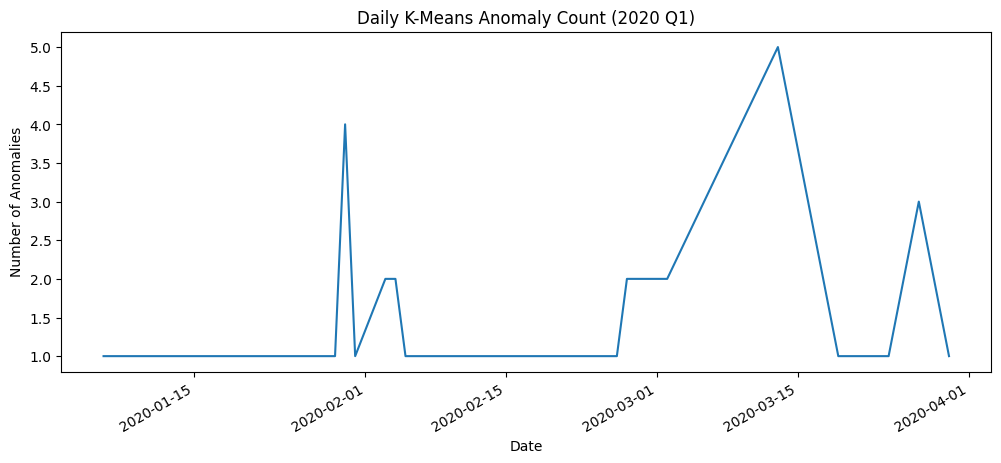

In [16]:
daily_counts = (
    df_kmeans_test
    .groupby("date")
    .size()
    .rename("kmeans_anomaly_count")
)

plt.figure(figsize=(12, 5))
daily_counts.plot()
plt.title("Daily K-Means Anomaly Count (2020 Q1)")
plt.ylabel("Number of Anomalies")
plt.xlabel("Date")
plt.show()


#### I: Rule-Based Vs K-Means Comparison & Flag Rate (Validation Set)

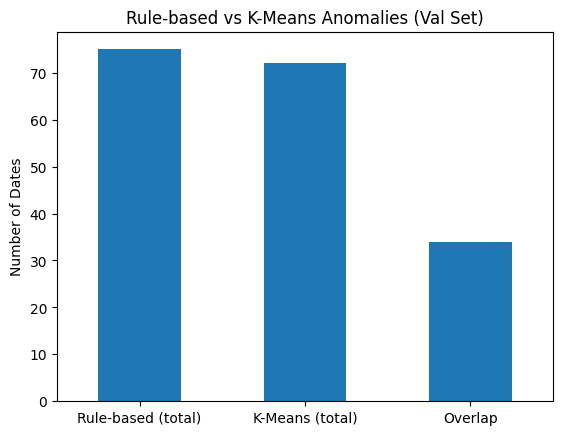

Rule Based anomalous days: 75
K-Means anomalous days : 72
Overlapping anomalous days: 34
Total Ticker Days (Val Set) : 1763
Total Anomaly Days (Val Set) : 97
Flag Rate on Validation Set: 5.50%


In [17]:
df_rule = detect_rule_anomaly(df_features)
df_rule = df_rule[
    df_rule["date"].dt.year == 2019 
]
rule_dates = set(df_rule["date"])
kmeans_dates_val = set(df_kmeans_val["date"])

overlap = rule_dates & kmeans_dates_val

counts = {
    "Rule-based (total)": len(rule_dates),
    "K-Means (total)": len(kmeans_dates_val),
    "Overlap": len(overlap)
}

pd.Series(counts).plot(kind="bar", title="Rule-based vs K-Means Anomalies (Val Set)")
plt.ylabel("Number of Dates")
plt.xticks(rotation=0)
plt.savefig("reports/figures/rule_vs_Kmeans_anomaly.png", bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()

print(f"Rule Based anomalous days: {len(rule_dates)}")
print(f"K-Means anomalous days : {len(kmeans_dates_val)}")
print(f"Overlapping anomalous days: {len(overlap)}")

print(f"Total Ticker Days (Val Set) : {len(meta_val)}")
print(f"Total Anomaly Days (Val Set) : {len(df_kmeans_val)}")
print(f"Flag Rate on Validation Set: {(len(df_kmeans_val) / len(meta_val)) * 100:.2f}%")


#### Rule-Based vs K-Means Comparison (Test Set)

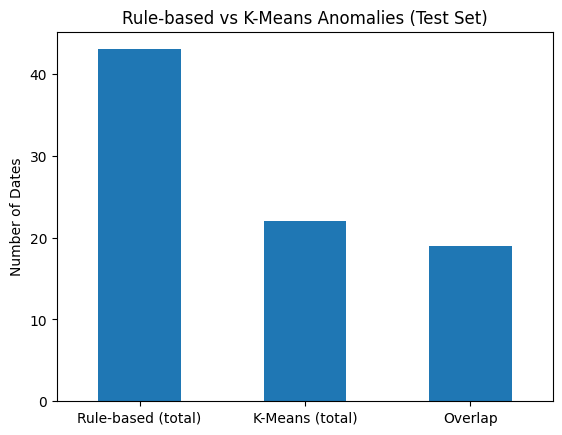

Rule Based Anomaly Count : 43
K-Means Anomaly Count : 22
Overlapping Anomaly Count: 19


In [18]:
df_rule = detect_rule_anomaly(df_features)
df_rule_test = df_rule[
    (df_rule["date"] >= "2020-01-01") &
    (df_rule["date"] <= "2020-03-31")
]
rule_dates = set(df_rule_test["date"])
kmeans_dates = set(df_kmeans_test["date"])

overlap = rule_dates & kmeans_dates

counts = {
    "Rule-based (total)": len(rule_dates),
    "K-Means (total)": len(kmeans_dates),
    "Overlap": len(overlap)
}

pd.Series(counts).plot(kind="bar", title="Rule-based vs K-Means Anomalies (Test Set)")
plt.ylabel("Number of Dates")
plt.xticks(rotation=0)
plt.savefig("reports/figures/rule_vs_Kmeans_anomaly.png", bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()

print(f"Rule Based Anomaly Count : {len(rule_dates)}")
print(f"K-Means Anomaly Count : {len(kmeans_dates)}")
print(f"Overlapping Anomaly Count: {len(overlap)}")

#### Persisting the data 

In [19]:
OUT_DIR = Path("data/processed")

df_features.to_csv(OUT_DIR / "features.csv", index=False)
df_kmeans_test.to_csv(OUT_DIR / "anomalies_kmeans_test.csv", index=False)
df_rule_test.to_csv(OUT_DIR / "anomalies_rule_test.csv", index=False)